In [1]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Load data and set AOI

- Lists available images and sorts them according to the acquisition date
- Loads RPC coefficients from the images
- Displays Geographical footprints
- Selects the Area Of Interest in World Geodetic System (WGS84) coordinates, i.e. lon-lat

In [ ]:
# list the tiff images available in the remote folder
IARPAurl = 'http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif'
myimages = utils.listFD(IARPAurl, 'TIF')

# sort the images by acquisition date
myimages = sorted(myimages, key=utils.acquisition_date)
myimages.pop(11)
myimages.pop(13)
myimages.pop(19)
print('Found {} images'.format(len(myimages)))

# select the number of cameras for the current run
#myimages = myimages[37:43]
myimages = myimages[37:40]
myimages = myimages[::-1]
n_cam = len(myimages)
print('Number of images to be used:', n_cam)

# load RPC coefficients
myrpcs = [utils.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# creates an interactive map and returns a map handle to interact with it.
mymap = vistools.clickablemap(zoom=12)
display(mymap)

# display the footprint polygons of the satellite images 
for f in range(n_cam):    
    footprint = utils.get_image_longlat_polygon(myimages[f])
    mymap.add_GeoJSON(footprint)

# set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
aoi_buenos_aires = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                                     [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
aoi_buenos_aires['center'] = np.mean(aoi_buenos_aires['coordinates'][0][:4], axis=0).tolist() # add center field

# center the map on the center of the footprint
mymap.center = np.mean(footprint['coordinates'][0][:4], axis=0).tolist()[::-1]

# add a polygon and center the map
mymap.add_GeoJSON(aoi_buenos_aires)  # this draws the polygon described by aoi
mymap.center = aoi_buenos_aires['center'][::-1]  # aoi_buenos_aires['coordinates'][0][0][::-1] 

# get the altitude of the center of the AOI
lon, lat = aoi_buenos_aires['center']
z = srtm4.srtm4(lon, lat)

### Crop AOI

- Crops the AOI from all satellite images

In [ ]:
import cv2
# crop the selected AOI in each image
mycrops, im = [], []
for f in range(len(myimages)):
    crop, x0, y0 = utils.crop_aoi(myimages[f], aoi_buenos_aires, z)
    mycrops.append({ 'crop': utils.simple_equalization_8bit(crop), 'x0': x0, 'y0': y0 })
    im.append(utils.simple_equalization_8bit(crop))
    #cv2.imwrite('ba_experiments/crops/image_{}.png'.format(f), im[-1])
vistools.display_gallery(im)

### Approximate RPCs as projective matrices

- Approximate the RPCs of the input images as 3x4 projective matrices

In [ ]:
# set the camera model to be used: Affine, anything else will be treated as Perspective
cam_model = 'Perspective'

P_crop = []
if cam_model == 'Affine':
    # all affine cameras have to be approximated at the same local point
    p_geodetic = [aoi_buenos_aires['center'][0], aoi_buenos_aires['center'][1], 31.0] # lon, lat, alt
    #print('geodetic:', p_geodetic)
    p_x, p_y, p_z = ba_utils.latlon_to_ecef_custom(p_geodetic[1], p_geodetic[0], p_geodetic[2])
    p_geocentric = [p_x, p_y, p_z]
    #print('geocentric:', p_geocentric)
    for rpc, crop in zip(myrpcs, mycrops):
        P_img = rectification.rpc_affine_approximation2(rpc, p_geocentric)
        x, y, w, h = utils.bounding_box_of_projected_aoi(rpc, aoi_buenos_aires, rpc.alt_offset)
        T_crop = np.array([[1., 0., -crop['x0']], [0., 1., -crop['y0']], [0., 0., 1.]])
        current_P = T_crop @ P_img
        #P_crop.append(current_P)
        P_crop.append(current_P/current_P[2,3])

        # check that the decomposition of affine matrices works properly:
        #K, R, vecT = ba_utils.decompose_affine_camera(P_crop[-1])
        #Preconstructed = np.vstack( (np.hstack((K @ R[:2,:], vecT.T)), np.array([[0,0,0,1]])) )
        #print(np.allclose(P_crop[-1], Preconstructed/Preconstructed[2,3]))  
    print('RPCs successfully approximated as affine cameras')
else:
    os.chdir('../s2p/')
    from s2plib.rpc_utils import approximate_rpc_as_projective, rpc_from_geotiff
    myrpcs2 = [rpc_from_geotiff(x) for x in myimages]
    for rpc, rpc2, crop in zip(myrpcs, myrpcs2, mycrops):
        # approximate current rpc as a projective 3x4 matrix
        x, y, w, h = utils.bounding_box_of_projected_aoi(rpc, aoi_buenos_aires, rpc.alt_offset)
        P_img = approximate_rpc_as_projective(rpc2, [x,x+w,10], [y,y+h,10], \
                                                    [rpc2.altOff - 100, rpc2.altOff + 100, 10], verbose=False)
        #express P in terms of crop coord by applying the translation x0, y0 (i.e. top-left corner of the crop)
        T_crop = np.array([[1., 0., -crop['x0']], [0., 1., -crop['y0']], [0., 0., 1.]])
        current_P = T_crop @ P_img
        P_crop.append(current_P/current_P[2,3])

        # check that the decomposition of perspective matrices works properly:
        #K, R, vecT, C = ba_utils.decompose_projection_matrix(P_crop[-1])
        #Preconstructed = K @ R @ np.hstack((np.eye(3), - C[:, np.newaxis]))
        #print(np.allclose(P_crop[-1], Preconstructed/Preconstructed[2,3]))      
    print('RPCs successfully approximated as perspective cameras')
    os.chdir('../IS18/')

In [ ]:
P_crop

### Alternative: Instead of using the IARPA dataset, read another dataset from folder

In [ ]:
import glob

# load images from folder and rpcs from TXT

seq_id = '20190126_182329'
input_dir = os.path.join('ba_experiments/exp_strips/',seq_id)

# read tiff images 
myimages = glob.glob(input_dir+'/*.tif')
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })
#vistools.display_gallery(mycrops)

# load RPC coefficients
os.chdir('../s2p/')
from s2plib import rpc_model
myrpcs2 = [rpc_model.RPCModel('../IS18/'+os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
print('Finished loading RPC coefficients')
os.chdir('../IS18/')

# approximate rpcs as a as projective matrices
os.chdir('../s2p/')
from s2plib import rpc_utils
cam_model = 'Perspective'
P_crop = []
for rpc2, crop in zip(myrpcs2, mycrops):
    x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
    P_img = rpc_utils.approximate_rpc_as_projective(rpc2, [x,x+w,10], [y,y+h,10], \
                                                    [rpc2.altOff - 100, rpc2.altOff + 100, 10], verbose=False)
    P_crop.append(P_img/P_img[2,3])
print('RPCs successfully approximated as projection matrices')
os.chdir('../IS18/')

### Read SkySat data

In [2]:
import glob
import csv
import pymap3d
import dateutil.parser

# read tiff images

input_dir = 'ba_experiments/exp_skysat'

exp = '3s_6views'

myimages = glob.glob(input_dir+'/'+exp+'/*.tiff')
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })
#vistools.display_gallery(mycrops)

# read camera parameters

myfilenames = [os.path.splitext(os.path.basename(image))[0] for image in myimages]

print('myfilenames:', myfilenames)

cam_data = []
file_in = input_dir + '/frame_index.csv'
for i in range(len(mycrops)):
    with open(file_in, 'r', encoding="utf-8") as t_in:
        t_in_reader = csv.DictReader(t_in)
        for row in t_in_reader:
            current_filename = row['name']
            if current_filename == myfilenames[i]:
                q0, q1, q2, q3 = float(row['q0']), float(row['q1']), float(row['q2']), float(row['q3'])
                cam_data.append({'name': current_filename,
                                 'date': dateutil.parser.parse(row['datetime']), 
                                 'x': float(row['x_sat_eci'])*1000.0, 
                                 'y': float(row['y_sat_eci'])*1000.0,
                                 'z': float(row['z_sat_eci'])*1000.0, 
                                 'q0': q0,
                                 'q1': q1,
                                 'q2': q2,
                                 'q3': q3,
                                 'w': 2560.0,
                                 'h': 1080.0,
                                 'f': 692307.69})
                if np.linalg.norm(np.array([q0, q1, q2, q3])) != 1.0:
                    print('Input quaternions are not unit vectors!')
                
#mycrops = mycrops[::-1]
#myfilenames = myfilenames[::-1]
#cam_data = cam_data[::-1]
                
def euler_to_quaternion(roll, pitch, yaw):

        qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
        qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
        qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
        qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)

        return [qx, qy, qz, qw]

def quaternion_to_euler(x, y, z, w):

        import math
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        X = np.arctan2(t0, t1)

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        Y = np.arcsin(t2)

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        Z = np.arctan2(t3, t4)

        return X, Y, Z

def quaternion_to_R(q0, q1, q2, q3):
    """Convert a quaternion into rotation matrix form.
    https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
    """
    matrix = np.zeros((3,3))
    
    # The diagonal.
    matrix[0, 0] = q0**2 + q1**2 - q2**2 - q3**2
    matrix[1, 1] = q0**2 - q1**2 + q2**2 - q3**2
    matrix[2, 2] = q0**2 - q1**2 - q2**2 + q3**2

    # Off-diagonal.
    matrix[0, 1] = 2.0 * (q1*q2 - q0*q3)
    matrix[0, 2] = 2.0 * (q0*q2 + q1*q3)
    matrix[1, 2] = 2.0 * (q2*q3 - q0*q1)

    matrix[1, 0] = 2.0 * (q1*q2 + q0*q3)
    matrix[2, 0] = 2.0 * (q1*q3 - q0*q2)
    matrix[2, 1] = 2.0 * (q0*q1 + q2*q3)  
    return matrix


# initialize projection matrices

cam_model = 'Perspective'
P_crop = []
for cam in cam_data:
    
    print('\n')
       
    # quaternion_to_R is equivalent to doing the following
    #ax, ay, az = quaternion_to_euler(cam['q1'], cam['q2'], cam['q3'], cam['q0'])
    #R_eci_from_cam = ba_utils.euler_angles_to_R(np.array([ax, ay, az]))
    
    eci_canonical_basis = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    print(cam['date'])
    dates = [cam['date'] for i in range(eci_canonical_basis.shape[0])]
    ecef_basis = pymap3d.eci2ecef(eci_canonical_basis, dates)
    R_ecef_from_eci = ecef_basis.T
    
    print(R_ecef_from_eci)
    
    R_eci_from_cam = quaternion_to_R(cam['q0'], cam['q1'], cam['q2'], cam['q3'])
    R_cam_from_ecef = np.linalg.inv(R_eci_from_cam) @ np.linalg.inv(R_ecef_from_eci)
    print(np.linalg.det(R_cam_from_ecef),  np.allclose(R_cam_from_ecef.T @ R_cam_from_ecef, np.eye(3)))
    
    C_eci = np.array([cam['x'],cam['y'],cam['z']])
    C_ecef = np.expand_dims(pymap3d.eci2ecef(C_eci, cam['date']), axis=1)
    
    K = np.array([[cam['f'], 0.0, float(cam['w'])/2], [0.0, cam['f'], float(cam['h'])/2], [0.0, 0.0, 1.0]])
    
    #current_P = K @ np.hstack(( R_cam_from_ecef, C_ecef))
    #current_P = K @ R_cam_from_ecef @ np.hstack((np.eye(3), -C_ecef))
    current_P = K @ R_cam_from_ecef @ np.hstack((np.eye(3), -C_ecef))
    
    #P_crop.append(current_P/current_P[2,3])
    P_crop.append(current_P)
    
print('\nRPCs successfully approximated as projection matrices')

Found 6 images
Number of images to be used: 6
myfilenames: ['1223201791.24831295_sc00003_c1_PAN', '1223201794.24880314_sc00003_c1_PAN', '1223201788.24781990_sc00003_c1_PAN', '1223201803.25027180_sc00003_c1_PAN', '1223201800.24978352_sc00003_c1_PAN', '1223201797.24929333_sc00003_c1_PAN']
Input quaternions are not unit vectors!
Input quaternions are not unit vectors!
Input quaternions are not unit vectors!
Input quaternions are not unit vectors!
Input quaternions are not unit vectors!
Input quaternions are not unit vectors!


2018-10-10 10:16:13+00:00
[[-0.99260506  0.12138857  0.        ]
 [-0.12138857 -0.99260506  0.        ]
 [ 0.          0.          1.        ]]
1.000000079113574 True


2018-10-10 10:16:16+00:00
[[-0.9926316   0.12117143  0.        ]
 [-0.12117143 -0.9926316   0.        ]
 [ 0.          0.          1.        ]]
0.999999522211632 True


2018-10-10 10:16:10+00:00
[[-0.99257849  0.12160572  0.        ]
 [-0.12160572 -0.99257849  0.        ]
 [ 0.          0.          1

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import glob
import csv
import pymap3d
import dateutil.parser

def quaternion_to_R(q0, q1, q2, q3):
    """Convert a quaternion into rotation matrix form.
    https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
    """
    matrix = np.zeros((3,3))
    
    # The diagonal.
    matrix[0, 0] = q0**2 + q1**2 - q2**2 - q3**2
    matrix[1, 1] = q0**2 - q1**2 + q2**2 - q3**2
    matrix[2, 2] = q0**2 - q1**2 - q2**2 + q3**2

    # Off-diagonal.
    matrix[0, 1] = 2.0 * (q1*q2 - q0*q3)
    matrix[0, 2] = 2.0 * (q0*q2 + q1*q3)
    matrix[1, 2] = 2.0 * (q2*q3 - q0*q1)

    matrix[1, 0] = 2.0 * (q1*q2 + q0*q3)
    matrix[2, 0] = 2.0 * (q1*q3 - q0*q2)
    matrix[2, 1] = 2.0 * (q0*q1 + q2*q3)  
    return matrix


# plot satellite trajectory

# read tiff images

input_dir = 'ba_experiments/exp_skysat'

exp = '9s'

myimages = glob.glob(input_dir+'/'+exp+'/*.tiff')
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })

# read camera parameters

myfilenames = [os.path.splitext(os.path.basename(image))[0] for image in myimages]
cam_data = []
file_in = input_dir + '/frame_index.csv'
with open(file_in, 'r', encoding="utf-8") as t_in:
    t_in_reader = csv.DictReader(t_in)
    X, rot_axis = [], []
    for row in t_in_reader:
        current_filename = row['name']
        #if current_filename in myfilenames:
        tmp = np.array([[float(row['x_sat_eci'])*1000, float(row['y_sat_eci'])*1000, float(row['z_sat_eci'])*1000]])
        current_date = dateutil.parser.parse(row['datetime'])
        X.append(pymap3d.eci2ecef(tmp, current_date))

        q0, q1, q2, q3 = float(row['q0']), float(row['q1']), float(row['q2']), float(row['q3'])
        R_eci_from_cam = quaternion_to_R(q0, q1, q2, q3)
        R_eci_from_cam = np.vstack((R_eci_from_cam[:,0], R_eci_from_cam[:,1], R_eci_from_cam[:,2])).T        

        eci_canonical_basis = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
        dates = [current_date for i in range(eci_canonical_basis.shape[0])]
        ecef_basis = pymap3d.eci2ecef(eci_canonical_basis, dates)

        R_ecef_from_eci = ecef_basis.T
        R_cam_from_ecef = np.linalg.inv(R_eci_from_cam) @ np.linalg.inv(R_ecef_from_eci)

        rot_matrix = np.linalg.inv(R_cam_from_ecef)
        rot_axis.append(rot_matrix)
        
X = np.array(X)
x, y, z = X[:,0], X[:,1], X[:,2]
s=1e6
print(X.shape)

fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)

#ax.scatter(x, y, z, c='b', s=0.5)

printearth = False

if printearth:
    earthradius = 6371.0e+3
    # the earth (sphere)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    xe = earthradius * np.outer(np.cos(u), np.sin(v))
    ye = earthradius * np.outer(np.sin(u), np.sin(v))
    ze = earthradius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(xe, ye, ze, rstride=4, cstride=4, color='c')

#for i in range(1,x.shape[0],700):
for i in range(x.shape[0]):
    t = rot_axis[i] @ np.array([[0], [0] , [1]])
    tx, ty, tz = x[i] + t[0]*s, y[i] + t[1]*s, z[i] + t[2]*s
    tx, ty, tz = tx[0], ty[0], tz[0]
    #ax.plot([x[i], tx], [y[i], ty], [z[i], tz], 'r-')
    ax.scatter(*X[i,:], c='b')
    
#ax.set_xlim(-1000000, 1000000)
#ax.set_ylim(-200000, 200000)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [ ]:
pts_3d, C = ba_utils.initialize_3d_points(P_crop_ba, C, cam_model, var_filt=False, var_hist=True)

print('Initial 3D points:\n', pts_3d)

# compare points in (lat, lon, alt) and (east, north) before and after BA
os.chdir('../s2p/')
from s2plib import geographiclib
os.chdir('../IS18/')

print('Before BA:')#354449.320, 6182457.920 - 10000000
os.chdir('../s2p/')
x , y, z = pts_3d[:,0], pts_3d[:,1], pts_3d[:,2]
lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
os.chdir('../IS18/')
print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
      .format(min(x), max(x), min(y), max(y), min(z), max(z)))
print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
      .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))

east, north = utils.utm_from_lonlat(lon, lat)
xyz = np.vstack((east, north, h)).T
ba_utils.write_point_cloud_ply('skysat_all.ply', xyz)

In [ ]:
#C = C[:,:500]
#pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)


col = np.array([[255, 0, 0],[0, 255, 0], [0, 0, 255]])
n_pts, n_cam = C.shape[1], int(C.shape[0]/2)
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba[q], P_crop_ba[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_ba_l2_R_focal_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])

In [ ]:
# compare points in (lat, lon, alt) and (east, north) before and after BA
os.chdir('../s2p/')
from s2plib import geographiclib
os.chdir('../IS18/')

#pts_3d, C = ba_utils.initialize_3d_points(P_crop_ba, C, cam_model, var_filt=False, var_hist=True)
pts_3d = pts_3d_ba.copy()
x , y, z = pts_3d[:,0], pts_3d[:,1], pts_3d[:,2]
os.chdir('../s2p/')
lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
os.chdir('../IS18/')
east, north = utils.utm_from_lonlat(lon, lat)
xyz = np.vstack((east, north, h)).T
ba_utils.write_point_cloud_ply('3s_ba_2_l2.ply', xyz)

In [ ]:
pts_3d - pts_3d_ba

In [83]:
p_ind = 979

 ----> Real 2D loc in im 0  (sol) =  [652.200684 317.550476]
 ----> Proj 2D loc in im 0  b. BA =  [654.66995398 326.87118332]
 ----> Real 2D loc in im 1  (sol) =  [642.381104 348.667267]
 ----> Proj 2D loc in im 1  b. BA =  [636.3080882  348.17107257]
 ----> Real 2D loc in im 2  (sol) =  [671.00708  292.848297]
 ----> Proj 2D loc in im 2  b. BA =  [665.8060168  283.73972452]
Reprojection error b. BA:  1547.695043443578


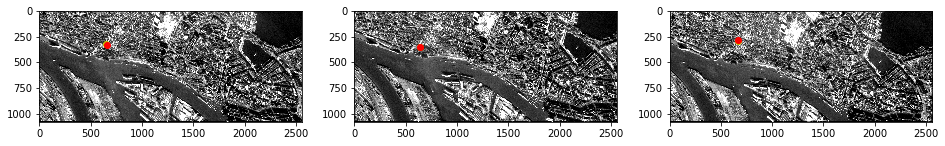

In [84]:
n_pts = C.shape[1]
#p_ind = pts_ind[np.argmax(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))] # idx of observation with max error
#p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    #proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    #p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    reprojection_error += np.sum(p_2d_proj - p_2d_gt) ** 2
    #reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2
    
    #if cont == 0:
        #print('3D location a. triangulation:', pts_3d[p_ind,:].ravel())
        #print('3D location a. bundle adjust:', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' b. BA = ', p_2d_proj.ravel())
    #print(' ----> Proj 2D loc in im', i, ' a. BA = ', p_2d_proj_ba.ravel(), '\n')
    
    im = 255.*np.ones((1000,1000))
    #f[cont].imshow(im.squeeze(), cmap="gray", vmin=0, vmax=255)
    f[cont].imshow((mycrops[i]['crop']), cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_proj_ba, "ro")
    
print('Reprojection error b. BA: ', reprojection_error)
#print('Reprojection error a. BA: ', reprojection_error_ba)

In [ ]:
### visualize initial reprojection errors

mode = 'output'

if mode == 'input':
    err = np.add.reduceat(abs(f0), np.arange(0, len(f0), 2))
else:
    err = np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2))

thr = np.quantile(err, 0.5)
print(thr)

thr = np.inf

in_e, ba_e = [], []


i = 0
pts_gt, pts_reproj = [], []
for j in range(C.shape[1]):
    if not np.isnan(C[i*2,j]):
        p_2d_proj = np.reshape(C[(i*2):(i*2+2),j], (2,1))
        proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[j,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1] 
        proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[j,:], np.ones(1))), axis=1)
        reproj_ba = proj[0:2,:] / proj[-1,-1]  
        abs_reproj_e = np.sum(abs(p_2d_proj - reproj))
        abs_reproj_e_ba = np.sum(abs(p_2d_proj - reproj_ba))
        
        in_e.append(abs_reproj_e)
        ba_e.append(abs_reproj_e_ba)
        
        if mode == 'input':
            tmp = abs_reproj_e
        else:
            tmp = abs_reproj_e_ba
        
        #print(abs_reproj_e)
        
        if tmp < thr:
            pts_gt.append(p_2d_proj)
            
            if mode == 'input':
                pts_reproj.append(reproj)
            else:
                pts_reproj.append(reproj_ba)
                
pts_gt, pts_reproj = np.array(pts_gt)[:,:,0], np.array(pts_reproj)[:,:,0]

print(pts_gt.shape[0])

print('mean abs reproj error in image {} is {}'.format(i, np.mean(ba_e))) 

# image 0
_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(in_e, bins=40); 
f[1].hist(ba_e, bins=40);

In [ ]:
K, R, vecT, C = ba_utils.decompose_projection_matrix(P_crop[0])
print(K)

K, R, vecT, C = ba_utils.decompose_projection_matrix(P_crop_ba[0])
print(K/K[-1,-1])

In [ ]:
f = plt.figure(figsize=(9,9))
plt.imshow((mycrops[i]['crop']), cmap="gray")
for i in range(pts_gt.shape[0]):
    plt.plot([pts_gt[i,0], pts_reproj[i,0] ], [pts_gt[i,1], pts_reproj[i,1]], 'r-')
    plt.plot(*pts_gt[i,:], 'yx')
    
plt.show()

In [ ]:
for cam in cam_data:
    print(cam['date'])

In [ ]:
myfilenames

In [ ]:
np.allclose(pts_3d_ba, pts_3d)

In [ ]:
plt.quiver(pts_gt[:,0], pts_gt[:,1], pts_reproj[:,0]-pts_gt[:,0], pts_reproj[:,1] - pts_gt[:,1])
plt.show()

### Create feature tracks 

- Find SIFT keypoints across all images
- Bruteforce matching of all pairs with all pairs
- Concatenate matches across different images to create feature tracks

In [4]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2

'''
FEATURE TRACKS REPRESENTATION
'feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
'r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'
'''

#mycrops = mycrops[::-1]

# (1) detect SIFT keypoints
features = []
for f in range(len(mycrops)):
    kp, des = ba_utils.find_SIFT_kp(mycrops[f]['crop'])
    features.append({ 'kp': kp, 'des': des })
    #im_kp=cv2.drawKeypoints(mycrops[f]['crop'],kp,outImage=np.array([]))
    #vistools.display_image(im_kp)

# (1) create feature tracks
tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
for i in range(n_cam):
    kp_i, des_i = features[i]['kp'], features[i]['des']
    for j in range(i+1,n_cam):
        kp_j, des_j = features[j]['kp'], features[j]['des']
        pts_i, pts_j, kp_i, kp_j, m_filt, m_all = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
        n_matches = 0 if pts_i is None else pts_i.shape[0]
        print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))
        
        # display matches for pair (i,j)
        #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
        #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))
        
        # if point i belongs to an existing track, then add point j... else, create new track
        for k in range(n_matches):
            xi, yi = pts_i[k,:]
            xj, yj = pts_j[k,:]
            list_of_existing_tracks_in_i = feature_tracks[:,:,i].tolist()
                
            if [xi, yi] in list_of_existing_tracks_in_i:
                existing_track_id = list_of_existing_tracks_in_i.index([xi, yi])
                feature_tracks[existing_track_id,:,j] = [xj, yj]
                r[existing_track_id,i], r[existing_track_id,j] = 1, 1
            else:
                tracks_id += 1
                new_track = np.zeros((1,2,n_cam))
                new_track[:,:,i], new_track[:,:,j]  = [xi, yi], [xj, yj]
                tmp = np.zeros((1,n_cam))
                tmp[:,i], tmp[:,j] = 1, 1
                feature_tracks, r = np.vstack((feature_tracks, new_track)), np.vstack((r, tmp))
                
feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
n_pts = feature_tracks.shape[0]
print('\nFound', n_pts, 'feature tracks.\n')

Pair (0,1) -> 16795 matches preserved out of 42357
Pair (0,2) -> 16345 matches preserved out of 42357
Pair (0,3) -> 8465 matches preserved out of 42357
Pair (0,4) -> 11427 matches preserved out of 42357
Pair (0,5) -> 14259 matches preserved out of 42357
Pair (1,2) -> 13309 matches preserved out of 42022
Pair (1,3) -> 11425 matches preserved out of 42022
Pair (1,4) -> 14320 matches preserved out of 42022
Pair (1,5) -> 17422 matches preserved out of 42022
Pair (2,3) -> 5939 matches preserved out of 43002
Pair (2,4) -> 8255 matches preserved out of 43002
Pair (2,5) -> 10847 matches preserved out of 43002
Pair (3,4) -> 17893 matches preserved out of 41986
Pair (3,5) -> 14622 matches preserved out of 41986
Pair (4,5) -> 17095 matches preserved out of 41898

Found 46272 feature tracks.



In [5]:
import pickle

#pickle_out = open("features_3s_6views.pickle","wb")
#pickle.dump([feature_tracks, r], pickle_out)
#pickle_out.close()

In [78]:
import pickle

pickle_in = open("features_3s.pickle","rb")
feature_tracks, r = pickle.load(pickle_in)

In [79]:
#Save feature tracks in txt (Correspondence matrix format)
#
# C = x11 ... x1n
#     y11 ... y1n
#     x21 ... x2n
#     y21 ... y2n
#     ... ... ...
#     xm1 ... xmn
#     ym1 ... ymn
#
# where (x11, y11) is the observation of feature track 1 in camera 1
#       (xm1, ym1) is the observation of feature track 1 in camera m
#       (x1n, y1n) is the observation of feature track n in camera 1
#       (xmn, ymn) is the observation of feature track n in camera m
#
# Consequently, the shape of C is  (2*number of cameras) x number of feature tracks
#
# If a given feature track does not contain an observation for a certain camera, that position is filled with NaN

C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)
#np.savetxt('ba_experiments/raw_sift_tracks.txt', C, delimiter = ' ') 

In [80]:
# remove uncomplete tracks
C = C[:, ~(np.sum((C!=C).astype(int), 0)).astype(bool)]

C.shape[1]

9920

In [81]:
C2 = np.zeros(C.shape)
C2[::2,:] = C[1::2,:]
C2[1::2,:] = C[::2, :]

C = C2

In [ ]:
#Load feature tracks from txt
C = np.loadtxt('ba_experiments/raw_sift_tracks.txt')

print(C)
print(C.shape)  # check shape of C 

In [ ]:
n_pts, n_cam = C.shape[1], int(C.shape[0]/2) 
q, p = 0, 1
pts_3d = np.zeros((n_pts,3))
for i in range(n_pts):
    pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
    P1, P2 = P_crop[q], P_crop[p]
    pts_3d[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)

### Alternative: Use ASIFT

Warning: this is super slow

In [ ]:
import asift

#ATENTTION: the asift.py implementation used in this cell is a simple adaptation of that of opencv
#           https://github.com/opencv/opencv/blob/master/samples/python/asift.py

# create feature tracks 
tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
for i in range(n_cam):
    for j in range(i+1,n_cam):
        pts_i, pts_j, kp_i, kp_j, m_filt, m_all = asift.match_pair(mycrops[i]['crop'], mycrops[j]['crop'], 'sift')
        n_matches = 0 if pts_i is None else pts_i.shape[0]
        print('Pair ({},{}) -> {} matches'.format(i,j,n_matches))

        # display matches for pair (i,j)
        #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
        #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

        # if point i belongs to an existing track, then add point j... else, create new track
        for k in range(n_matches):
            xi, yi = pts_i[k,:]
            xj, yj = pts_j[k,:]
            list_of_existing_tracks_in_i = feature_tracks[:,:,i].tolist()
            if [xi, yi] in list_of_existing_tracks_in_i:
                existing_track_id = list_of_existing_tracks_in_i.index([xi, yi])
                feature_tracks[existing_track_id,:,j] = [xj, yj]
                r[existing_track_id,i], r[existing_track_id,j] = 1, 1
            else:
                tracks_id += 1
                new_track = np.zeros((1,2,n_cam))
                new_track[:,:,i], new_track[:,:,j]  = [xi, yi], [xj, yj]
                tmp = np.zeros((1,n_cam))
                tmp[:,i], tmp[:,j] = 1, 1
                feature_tracks, r = np.vstack((feature_tracks, new_track)), np.vstack((r, tmp))

feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
n_pts = feature_tracks.shape[0]
print('\nFound', n_pts, 'feature tracks.\n')

### Initialize 3D points

- Initialize the 3D point corresponding to each feature track. 
- How? Pick the average value of all possible triangulated points within each track.

In [82]:
pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

print('Initial 3D points:\n', pts_3d)

Initial 3D points:
 [[3734176.18997483  637818.62477249 5114828.73213053]
 [3735203.64539878  637714.70045192 5114050.49253681]
 [3735053.89934054  637722.13872207 5114155.12334978]
 ...
 [3734655.02883382  637461.91898853 5119163.34422408]
 [3735294.93555269  637449.54571118 5118744.14593185]
 [3734765.24918971  637477.39133719 5119113.90600662]]


In [ ]:
# re-init

pts_3d, C = ba_utils.initialize_3d_points(P_crop_ba, C, cam_model, var_filt=False, var_hist=True)
P_crop = P_crop_ba

print('Initial 3D points:\n', pts_3d)

### Define BA input parameters

In [66]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{} cam_params_opt.shape:{}\n'.format(pts_3d.shape, cam_params.shape, cam_params_opt.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

pts_2d.shape:(29760, 2)  pts_ind.shape:(29760,)  cam_ind.shape:(29760,)
pts_3d.shape:(9920, 3)  cam_params.shape:(3, 11) cam_params_opt.shape:(3, 3)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


In [ ]:
pts_3d_check = np.zeros((C.shape[1], 3))
for j in range(C.shape[1]):
    
    P1, P2 = P_crop_ba[0], P_crop_ba[1] 
    
    proj = P1 @ np.expand_dims(np.hstack((pts_3d_ba[j,:], np.ones(1))), axis=1)
    reproj_0 = proj[0:2,:] / proj[-1,-1]  
    proj = P2 @ np.expand_dims(np.hstack((pts_3d_ba[j,:], np.ones(1))), axis=1)
    reproj_1 = proj[0:2,:] / proj[-1,-1]     
    
    pts_3d_check[j,:] = ba_utils.linear_triangulation_single_pt(reproj_0,reproj_1,P1,P2)

In [ ]:
np.allclose(pts_3d_check, pts_3d_ba)

In [ ]:
# visualize the observations in each image
features_x_img, features_on_img = [], []
for i in range(n_cam):
    tmp_pts = []
    for j in range(len(cam_ind)):
        if cam_ind[j] == i:
            tmp_pts.append(pts_2d[j])
    features_x_img.append(len(tmp_pts))

    a = np.array(tmp_pts)
    fig = plt.figure()
    fig.add_subplot(111)
    plt.imshow((mycrops[i]['crop']), cmap="gray")
    plt.scatter(x=np.round(a[:,0]), y=np.round(a[:,1]), c='r', s=4.0)
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    features_on_img.append(data)

vistools.display_gallery(features_on_img)

In [ ]:
max(pts_2d[:,0]) # col
max(pts_2d[:,1]) # row

In [68]:
# set weight of the observations according to their spatial distribution in each image

im_h, im_w = mycrops[0]['crop'].shape
rows_per_s, cols_per_s = np.floor(float(im_h)/3).astype(int), np.floor(float(im_w)/3).astype(int)
total_pts = pts_2d.shape[0]
n_slices = 9
pts_per_slice = np.zeros((3,3))
pts_2d_w = np.zeros(total_pts)

for s_row in range(3):
    rows_bottom_limit, rows_upper_limit = s_row*rows_per_s, (s_row+1)*rows_per_s
    for s_col in range(3):
        cols_left_limit, cols_right_limit = s_col*cols_per_s, (s_col+1)*cols_per_s      

        true_cols = np.logical_and(pts_2d[:,0] > cols_left_limit, pts_2d[:,0] <= cols_right_limit)
        true_rows = np.logical_and(pts_2d[:,1] > rows_bottom_limit, pts_2d[:,1] <= rows_upper_limit)
        true_cols_and_rows = np.logical_and(true_cols, true_rows)
        pts_s = np.sum(1*true_cols_and_rows)
        
        '''
        if s_row == 1 and s_col == 1:
            pts_2d_w[true_cols_and_rows] = 1e-6
        elif s_row == 0 and s_col == 1:
            pts_2d_w[true_cols_and_rows] = 1e-6
        elif s_row == 2 and s_col == 1:
            pts_2d_w[true_cols_and_rows] = 1e-6
        else:
            pts_2d_w[true_cols_and_rows] = pts_s
        '''
        
        pts_2d_w[true_cols_and_rows] = 1.0/pts_s
        
        pts_per_slice[s_row, s_col] = pts_s
        
        print('pts in slice ({},{}): {}'.format(s_row, s_col, pts_s))

print('\nTotal amount of observations:', np.sum(pts_per_slice[:]).astype(int))

print(pts_2d_w)
#print(np.sum(pts_2d_w))

pts_2d_w = (pts_2d_w/np.sum(pts_2d_w))*pts_2d_w.shape[0]

print(np.sum(pts_2d_w))


pts in slice (0,0): 4610
pts in slice (0,1): 4496
pts in slice (0,2): 2128
pts in slice (1,0): 1534
pts in slice (1,1): 4463
pts in slice (1,2): 3809
pts in slice (2,0): 2606
pts in slice (2,1): 3293
pts in slice (2,2): 2821

Total amount of observations: 29760
[0.00021692 0.00021692 0.00021692 ... 0.00026254 0.00046992 0.00026254]
29760.0


In [ ]:
cam_ind.shape

### Run BA

Shape of matrix A: 59520x29769
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.9212e+05                                    3.07e+10    
       1             12         7.5024e+05      1.42e+05       1.39e+03       2.09e+10    
       2             13         6.3672e+05      1.14e+05       1.72e+02       2.05e+10    
       3             14         5.9218e+05      4.45e+04       4.50e+02       2.74e+10    
       4             15         5.6739e+05      2.48e+04       2.09e+02       1.71e+10    
       5             16         5.6056e+05      6.84e+03       6.95e+02       1.37e+10    
       6             17         5.5438e+05      6.18e+03       7.34e+02       1.21e+10    
       7             18         5.4968e+05      4.70e+03       8.25e+02       1.22e+10    
       8             19         5.4478e+05      4.89e+03       8.01e+02       1.29e+10    
       9             20         5.4066e+05      4.13e+03   

      89             100        2.6944e+05      3.72e+03       7.56e+02       1.23e+10    
      90             101        2.6779e+05      1.65e+03       7.61e+02       1.21e+10    
      91             102        2.6407e+05      3.72e+03       7.60e+02       1.21e+10    
      92             103        2.6251e+05      1.57e+03       7.65e+02       1.20e+10    
      93             104        2.5880e+05      3.71e+03       7.64e+02       1.19e+10    
      94             105        2.5732e+05      1.48e+03       7.70e+02       1.18e+10    
      95             106        2.5362e+05      3.70e+03       7.68e+02       1.17e+10    
      96             107        2.5221e+05      1.41e+03       7.73e+02       1.17e+10    
      97             108        2.4850e+05      3.71e+03       7.71e+02       1.16e+10    
      98             109        2.4716e+05      1.34e+03       7.75e+02       1.16e+10    
      99             110        2.4579e+05      1.37e+03       1.94e+02       1.15e+10    

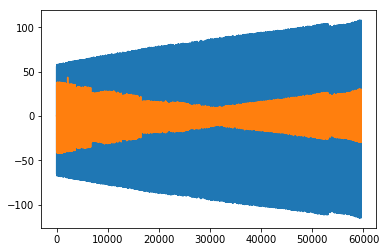

In [69]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    n_p = ba_params['n_params']
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
    print(x0.shape)
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-8, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
cam_idx = 2
print(cam_params[cam_idx,-5:])
print(cam_params_ba[cam_idx,-5:])
print(np.allclose(cam_params[cam_idx,:],cam_params_ba[cam_idx,:]))

cam_idx = 1
print(cam_params[cam_idx,-5:])
print(cam_params_ba[cam_idx,-5:])
print(np.allclose(cam_params[cam_idx,:],cam_params_ba[cam_idx,:]))

cam_idx = 0
print(cam_params[cam_idx,-5:])
print(cam_params_ba[cam_idx,-5:])

print(np.allclose(cam_params[0,-5:],cam_params[1,-5:], cam_params[2,-5:]))

In [ ]:
myfilenames

Error before BA (mean / median): 60.85 / 73.45
Error after  BA (mean / median): 8.89 / 6.11


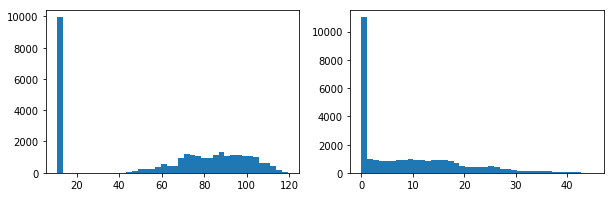

In [70]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)
#des_norm[des_norm == 0.0] = 1.0

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

### Remove outlier observations and re-initialize 3D points

In [ ]:
# remove outlier observations according to the reprojection error after BA
ba_input_err = np.add.reduceat(abs(f0), np.arange(0, len(f0), 2))
ba_output_err = np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2))
C = ba_utils.remove_outlier_obs_after_ba(ba_input_err, pts_ind, cam_ind, C, outlier_thr=100.0)

'''
# re-initialize 3d points
pts_3d, C = ba_utils.initialize_3d_points(P_crop_ba, C, cam_model, var_filt=False)

# re-define BA parameters
pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Euler', opt_X=True, opt_R=True)

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{}'.format(pts_3d.shape, cam_params.shape))
print('\nBundle Adjustment parameters defined')
'''

In [ ]:
#C = np.around(C, 6)
#np.savetxt('ba_experiments/clean_sift_tracks_last.txt', C, delimiter = ' ') 

In [ ]:
C = np.loadtxt('ba_experiments/clean_sift_tracks.txt')

# re-initialize 3d points
pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False)

# re-define BA parameters
pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Rodrigues', opt_X=True, opt_R=True)

In [ ]:
import time
from scipy.optimize import least_squares, minimize

# compute loss value and plot residuals at the initial parameters
x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, #loss='soft_l1', f_scale = 5.0,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
# check BA error performance
init_e = np.sort(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [ ]:
P_crop_ba

In [ ]:
# plot feature graph
# based on https://bibhasdn.com/blog/visualizing-networks-with-python-and-networkx/

C = np.loadtxt('ba_experiments/clean_sift_tracks.txt')
thr_matches = 41
A = ba_utils.plot_connectivity_graph(C, thr_matches, save_pgf=False)

A[A>=150] = 150
fig = plt.figure()
ax = fig.add_subplot(111);
cax = ax.matshow(A);
fig.colorbar(cax);

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#print soft L1 function
x = np.linspace(-3,3,1000)
z = x ** 2 
rho = 2 * ((1 + z)**0.5 - 1)

fig = plt.gcf()
#fig.set_size_inches(10, 3)
fig.set_size_inches(6,5)
#plt.subplot(121)
plt.plot(x,z, label='L2')
#plt.title('L2 loss')
#plt.subplot(122)
plt.plot(x,rho, label='Soft L1')
#plt.title('soft L1 loss')
plt.plot(x,abs(x), label='L1')

params = {'legend.fontsize': 16,
          'legend.handlelength': 2}
plt.rcParams.update(params)

plt.legend(loc='upper right')
plt.show()

In [ ]:
# display histogram of L2 distances for the 3d points before and after BA
dist = np.linalg.norm(pts_3d-pts_3d_ba, axis=1)
plt.hist(dist, bins=25);

'''
pts_3d  = pts_3d[dist<50.]
r = r[dist<50.,:]
feature_tracks = feature_tracks[dist<50.,:,:]
n_pts = feature_tracks.shape[0]
'''

print('Did the 3D points change?', not np.allclose(pts_3d_ba, pts_3d))
print(pts_3d[0])
print(pts_3d_ba[0],'\n')

print('Did the camera prameters change?', not np.allclose(cam_params_ba, cam_params))
print(cam_params[0])
print(cam_params_ba[0])

In [ ]:
# check that the conversion from P to cam_params and vice-versa works
for i in range(n_cam):
    a, b = ba_utils.ba_cam_params_from_P(P_crop[i], cam_model, R_params='Euler')
    current_P = ba_utils.ba_cam_params_to_P(cam_params[i,:], properR_axis[i], cam_model)
    if not np.allclose(current_P,P_crop[i]):
        print('Conversion from P to cam_params not working!')

#write PLY files containing the different cameras
for i in range(n_cam):
    #P_before_ba = ba_utils.ba_cam_params_to_P(cam_params_init[i,:], proper_R_axis[i])
    #ba_utils.write_ply_cam(P_before_ba, mycrops[i], 'cam/cam_{0:0=2d}_init.ply'.format(i), s=1000.0)
    P_after_ba = ba_utils.ba_cam_params_to_P(cam_params_ba[i,:], properR_axis[i], cam_model)
    ba_utils.write_ply_cam(P_after_ba, mycrops[i], 'cam/cam_{0:0=2d}_ba.ply'.format(i), s=1000.0)
print('\nCameras written\n')

In [ ]:
# compare points in (lat, lon, alt) and (east, north) before and after BA
os.chdir('../s2p/')
from s2plib import geographiclib
os.chdir('../IS18/')

print('Before BA:')
os.chdir('../s2p/')
x , y, z = pts_3d[:,0], pts_3d[:,1], pts_3d[:,2]
lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
os.chdir('../IS18/')
east, north = utils.utm_from_lonlat(lon, lat)
xyz = np.vstack((east, north, h)).T
ba_utils.write_point_cloud_ply('points_init.ply', xyz)
print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
      .format(min(x), max(x), min(y), max(y), min(z), max(z)))
print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
      .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))

print('\nAfter BA:')
os.chdir('../s2p/')
x , y, z = pts_3d_ba[:,0], pts_3d_ba[:,1], pts_3d_ba[:,2]
lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
os.chdir('../IS18/')
east, north = utils.utm_from_lonlat(lon, lat)
xyz = np.vstack((east, north, h)).T
ba_utils.write_point_cloud_ply('points_ba.ply', xyz)
print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
      .format(min(x), max(x), min(y), max(y), min(z), max(z)))
print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
      .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))

### Display the projections of a feature track before and after BA

- Display the projection of a 3D point in all images where visible, before and after BA
- Verify that the rerojection error is indeed smaller

In [ ]:
n_pts = C.shape[1]
p_ind = pts_ind[np.argmax(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(13,10))
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    reprojection_error += np.sum(p_2d_proj - p_2d_gt) ** 2
    reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2
    
    if cont == 0:
        print('3D location a. triangulation:', pts_3d[p_ind,:].ravel())
        print('3D location a. bundle adjust:', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' b. BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' a. BA = ', p_2d_proj_ba.ravel(), '\n')
    
    im = 255.*np.ones((1000,1000))
    f[cont].imshow(im.squeeze(), cmap="gray", vmin=0, vmax=255)
    f[cont].imshow((mycrops[i]['crop']), cmap="gray")
    f[cont].plot(*p_2d_gt, "go")
    f[cont].plot(*p_2d_proj, "bo")
    f[cont].plot(*p_2d_proj_ba, "ro")
    
print('Reprojection error b. BA: ', reprojection_error)
print('Reprojection error a. BA: ', reprojection_error_ba)

In [ ]:
#count how many of the pairs of the completeness criteria are also listed with the sift matches criteria

n_pairs = 50
oracle_pairs = ba_utils.get_predefined_pairs('ba_experiments/pairs/order_using_sift.txt')[:n_pairs]
sift_pairs = ba_utils.get_predefined_pairs('ba_experiments/pairs/order_using_completeness.txt')[:n_pairs]

cont = 0
for pair in sift_pairs:
    inv_pair = (pair[1], pair[0])
    if pair in oracle_pairs:
        cont += 1
    if inv_pair in oracle_pairs:
        cont += 1
print('The SIFT and ORACLE orders share {} input stereo pairs of the best {} pairs'.format(cont, n_pairs))

In [ ]:
from PIL import Image

directori = 'ba_experiments/50pairs_iarpa/rcdsm'

dsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(directori)][0]

cont = 0
features_on_img = []
for filename in dsm_files:
    # to visualize the rotation angle (rad) between the camera rotation of each pair
    #i, j = int(filename[6:8]), int(filename[9:11])
    #_, R_i, _, _ = ba_utils.decompose_projection_matrix(P_crop[i])
    #_, R_j, _, _ = ba_utils.decompose_projection_matrix(P_crop_ba[i])
    #axis, theta = ba_utils.axis_angle_from_R(R_i @ np.linalg.inv(R_j))
    #print(cont, '-->', filename, '{:.9f}'.format(theta))
    print(cont, '-->', filename)
    current_dem = np.array(Image.open(directori+'/'+filename))
    fig = plt.figure()
    fig.add_subplot(111)
    plt.imshow(current_dem.squeeze(), cmap='jet', vmin=-10, vmax=40) 
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    features_on_img.append(data)
    cont += 1

vistools.display_gallery(features_on_img)

In [ ]:
from PIL import Image

# read the ground truth geotiff  
gt_dsm = np.array(Image.open('ba_experiments/50pairs_v10/sol_dsm.tif'))
lon, lat = np.array([-58.585185]), np.array([-34.48922])
east, north = utils.utm_from_lonlat(lon, lat)

# write the necessary data from gdalinfo (northing (y) needs to be expressed in negative coordinates)
epsg, x, y, px_size = 32721, 354449.320, 6182457.920 - 10000000, 0.300000011920929

# attention: the top-left corner from the gt tiff and the one from the aoi are not exactly coincident

# save the gt geotiff but this time with northing in negative coordinates
ba_utils.save_geotiff('ba_experiments/50pairs_v10/sol_dsm2.tif', gt_dsm.astype(np.float64), epsg, x, y, r=px_size)

# elevate the geotiff we just wrote and write the point cloud in a ply file
os.system('bin/elevate ba_experiments/50pairs_v10/sol_dsm2.tif > ba_experiments/50pairs_v10/sol_cloud.txt')
xyz = ba_utils.read_point_cloud_txt('ba_experiments/50pairs_v10/sol_cloud.txt')
ba_utils.write_point_cloud_ply('ba_experiments/50pairs_v10/sol_cloud.ply', xyz)
